In [1]:
import jax.numpy as jnp
import numpy as np
import jax
import optax
import scipy
from scipy.spatial.distance import cdist
from scipy.integrate import RK45
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import equinox as eqx
import scipy.linalg
from jax.nn.initializers import variance_scaling
from jax.nn.initializers import he_normal
from tqdm import tqdm

seed = 42
np.random.seed(seed)
key = jax.random.key(seed)
batch_size = 64
num_branches = 40
num_trunk_epochs = 10000
num_branch_epochs = 10000
lr = 1e-5

# print("\nconfiguring backend...")
# jax.config.update("jax_platform_name", "metal")


# print("backend selected:\n", jax.default_backend())
# print("active devices:\n", jax.devices())
# print("--------------------\n")

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



W0000 00:00:1759805971.487741 70517508 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1759805971.510819 70517508 service.cc:145] XLA service 0x13fabd2c0 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759805971.510832 70517508 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1759805971.513514 70517508 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1759805971.513525 70517508 mps_client.cc:384] XLA backend will use up to 11452858368 bytes on device 0 for SimpleAllocator.


In [2]:
# Linear Model (Wx + b)
class Linear(eqx.Module):
    weight: jax.Array
    bias: jax.Array

    def __init__(self, in_size, out_size, key, initializer = he_normal()):
        wkey, bkey = jax.random.split(key)
        self.weight = initializer(wkey, (out_size, in_size), dtype=jnp.float32)
        self.bias = jnp.zeros((out_size,), dtype=jnp.float32)

    def __call__(self, x):
        return self.weight @ x + self.bias


# Basic MultiLayer Perceptron Primitive
class MLP(eqx.Module):
    layers: list
    activations: list

    def __init__(self, architecture, key, activation = jax.nn.relu, initializer = he_normal()):
        """
        architecture: List[in, hidden1, hidden2, ..., out]
        key: random key
        activation: jax.nn act fxn
        """
        keys = jax.random.split(key, len(architecture) - 1)
        self.layers = [
            Linear(architecture[i], architecture[i+1], keys[i], initializer = initializer) for i in range(len(architecture) - 1)]
        self.activations = [activation] * (len(self.layers) - 1) + [eqx.nn.Identity()] # no activation on last layer

    def __call__(self, x):
        for layer, act in zip(self.layers, self.activations):
            x = act(layer(x))
        return x

In [3]:
dataset = np.load('/Users/haydenoutlaw/Documents/Research/opnet/deep-operator-networks/data/burgers_dataset.npz', allow_pickle = True)
t_grid = jnp.array(dataset['t'])
x_grid = jnp.array(dataset['x'])
data = dataset['samples']
u = np.array([i['params'] for i in data])
s = np.array([i['solution'] for i in data])

n_samp = len(data)
train_indices, test_indices = train_test_split(np.arange(n_samp), test_size = 0.33, random_state = seed)
u_train, u_test = jnp.array(u[train_indices]), jnp.array(u[test_indices])
s_train, s_test = jnp.array(s[train_indices]), jnp.array(s[test_indices])


In [4]:
xx, tt = jnp.meshgrid(x_grid,t_grid)
xt_grid = jnp.concatenate([xx.flatten()[:,None], tt.flatten()[:,None]], axis=1)
print(xt_grid.shape)

ss_grid = s_train.reshape([-1, 40401]).T
print(ss_grid.shape)


(40401, 2)
(40401, 295)


In [5]:
u_dim = 2 # in this case, two 
y_dim = 2 # (x,t)
# define architectures for component networks
branch_arch = [u_dim, 40, 40, num_branches] 
trunk_arch  = [y_dim, 40, 40, num_branches] 

key, subkey_t, subkey_A = jax.random.split(key, num=3)
trunk_model = MLP(trunk_arch,key = subkey_t)
A_model = jax.random.normal(subkey_A, (num_branches, s_train.shape[0]))

model = trunk_model, A_model

def deeponet_step1(model, u_tr):
    trunk_model, A_model = model
    trunk_mat = jax.vmap(trunk_model)(u_tr)
    return (trunk_mat @ A_model)

def loss_fn(model, u, s):
    pred_y = deeponet_step1(model,u)
    return jnp.mean((s - pred_y) ** 2)

In [6]:
# equinox training step 
@eqx.filter_jit
def train_step(model, opt_state, x, y, opt_update):
    loss, grads = eqx.filter_value_and_grad(loss_fn)(model, x, y) # get loss and gradients
    updates, opt_state = opt_update(grads, opt_state, model) # update step
    model = eqx.apply_updates(model, updates) # apply updates
    return model, opt_state, loss


In [7]:
optim = optax.adam(lr)
opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))

trunk_train_hist, trunk_test_hist = [],[]

print("beginning branch training...")
for epoch in tqdm(range(num_branch_epochs)):
    
    model, opt_state, loss = train_step(model, opt_state, xt_grid, ss_grid, optim.update)

    trunk_train_hist.append(float(loss))



beginning branch training...


100%|██████████| 10000/10000 [02:26<00:00, 68.48it/s]


In [8]:
trunk_mat = np.array(jax.vmap(trunk_model)(xt_grid))
Q,R = scipy.linalg.qr(trunk_mat, mode = 'economic')
T = scipy.linalg.inv(R.T)

In [9]:
n_t, n_x = len(t_grid), len(x_grid)

# Reshape each orthogonalized function
orth_funcs = Q.reshape(n_t, n_x, -1)   # shape (nt, nx, num_branches)
print("orth_funcs shape:", orth_funcs.shape)  # (nt, nx, 40)

orth_funcs shape: (201, 201, 40)


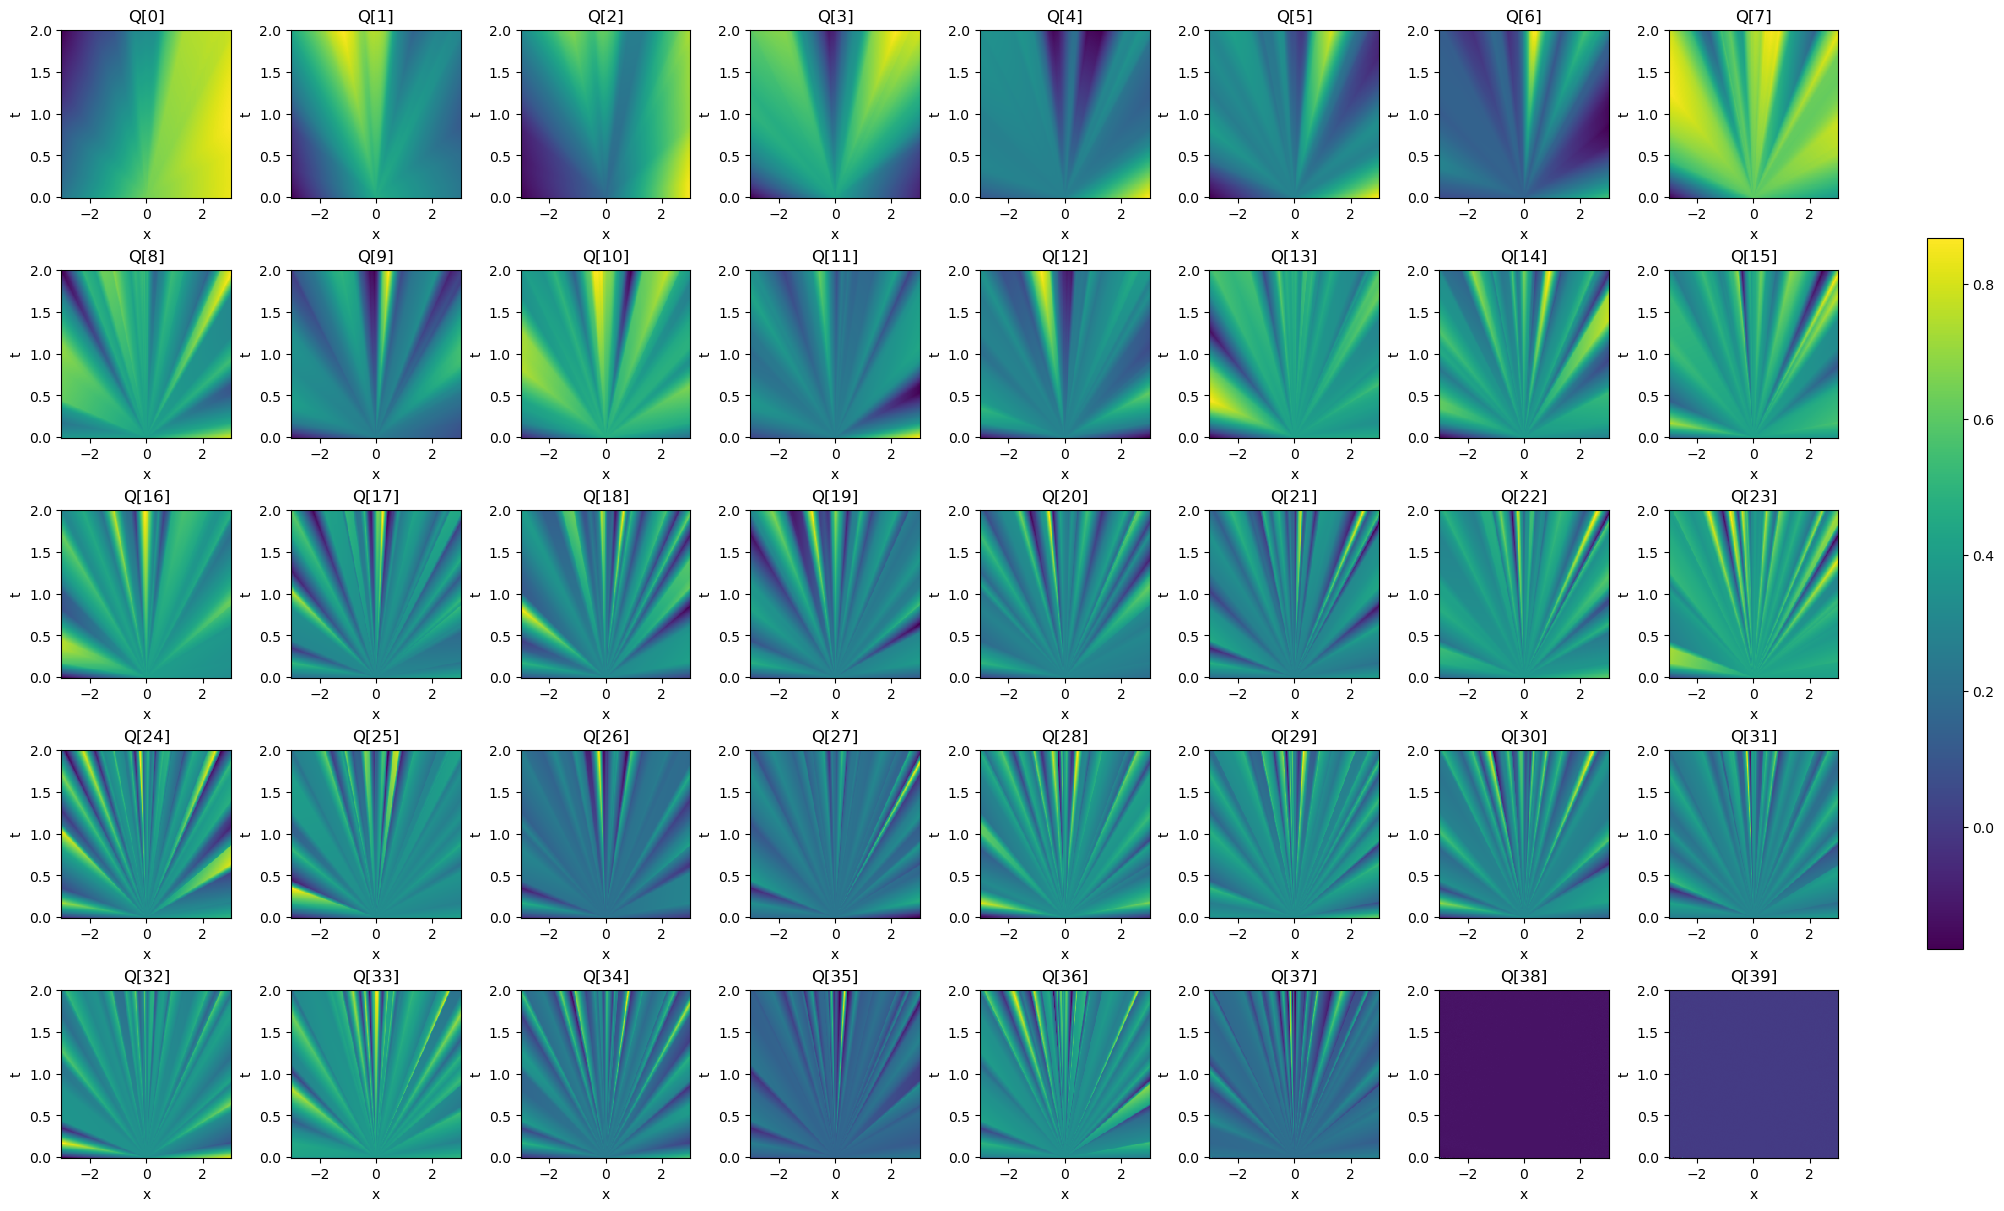

In [10]:
import matplotlib.pyplot as plt

num_funcs = orth_funcs.shape[-1]

fig, axes = plt.subplots(5, 8, figsize=(20, 12), constrained_layout=True)
for k, ax in enumerate(axes.flat):
    if k < num_funcs:
        im = ax.pcolormesh(x_grid, t_grid, orth_funcs[:,:,k], shading='auto')
        ax.set_title(f"Q[{k}]")
        ax.set_xlabel("x")
        ax.set_ylabel("t")
plt.colorbar(im, ax=axes, orientation="vertical", fraction=0.02)
plt.show()



In [11]:
print("A_model:", A_model.shape)
Q,R = scipy.linalg.qr(A_model, mode="economic")
print("R:", R.shape)

A_model: (40, 295)
R: (40, 295)
